In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import os

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)
os.makedirs('outputs/gridsearch', exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Preprocess Data

In [2]:
# Load census data
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv('census/adult.data', names=columns, na_values=' ?', skipinitialspace=True)

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['income'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Drop missing values
df = df.dropna()

# Encode target variable (Binary: 0 = <=50K, 1 = >50K)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split features and target
X = df.drop('income', axis=1)
y = df['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data preprocessed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Dataset shape: (32561, 15)

Target distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Missing values: 0

✓ Data preprocessed
Training set: (22792, 14)
Test set: (9769, 14)
Class distribution - Train: [17303  5489]
Class distribution - Test: [7417 2352]


## 2. Define Hyperparameter Grids for All 6 Classifiers

We'll test multiple values for each key hyperparameter to analyze sensitivity.

In [3]:
# Define hyperparameter grids for sensitivity analysis
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
}

# Base classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("✓ Hyperparameter grids defined")
print(f"\nTotal classifiers: {len(classifiers)}")
for name, grid in param_grids.items():
    total_combinations = np.prod([len(v) for v in grid.values()])
    print(f"{name}: {len(grid)} hyperparameters, {total_combinations} combinations")

✓ Hyperparameter grids defined

Total classifiers: 6
KNN: 3 hyperparameters, 28 combinations
Logistic Regression: 4 hyperparameters, 24 combinations
SVM: 3 hyperparameters, 60 combinations
MLP: 5 hyperparameters, 60 combinations
Decision Tree: 4 hyperparameters, 224 combinations
Naive Bayes: 1 hyperparameters, 7 combinations


## 3. Perform GridSearchCV for All Classifiers

This will test all hyperparameter combinations and find the best configuration for each classifier.

In [4]:
grid_results = {}
best_models = {}

print("="*80)
print("CENSUS INCOME - HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"GridSearchCV: {name}")
    print(f"{'='*80}")
    
    clf = classifiers[name]
    param_grid = param_grids[name]
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        clf, 
        param_grid, 
        cv=3, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    # Store results
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_,
        'all_scores': grid_search.cv_results_['mean_test_score'],
        'std_scores': grid_search.cv_results_['std_test_score']
    }
    best_models[name] = grid_search.best_estimator_
    
    # Test on test set
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    # Calculate sensitivity metrics
    score_variance = np.var(grid_search.cv_results_['mean_test_score'])
    score_std = np.std(grid_search.cv_results_['mean_test_score'])
    score_range = np.max(grid_search.cv_results_['mean_test_score']) - np.min(grid_search.cv_results_['mean_test_score'])
    
    grid_results[name]['test_accuracy'] = test_accuracy
    grid_results[name]['test_f1'] = test_f1
    grid_results[name]['variance'] = score_variance
    grid_results[name]['std'] = score_std
    grid_results[name]['range'] = score_range
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"\nHyperparameter Sensitivity:")
    print(f"  Variance: {score_variance:.6f}")
    print(f"  Std Dev: {score_std:.6f}")
    print(f"  Range: {score_range:.4f}")
    print(f"\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

print(f"\n{'='*80}")
print("✓ GridSearchCV completed for all classifiers")
print(f"{'='*80}")

CENSUS INCOME - HYPERPARAMETER SENSITIVITY ANALYSIS

GridSearchCV: KNN
Best CV Score: 0.8347
Test Accuracy: 0.8412
Test F1-Score: 0.6429

Hyperparameter Sensitivity:
  Variance: 0.000031
  Std Dev: 0.005528
  Range: 0.0215

Best Parameters:
  metric: manhattan
  n_neighbors: 21
  weights: distance

GridSearchCV: Logistic Regression
Best CV Score: 0.8245
Test Accuracy: 0.8264
Test F1-Score: 0.5602

Hyperparameter Sensitivity:
  Variance: 0.000216
  Std Dev: 0.014697
  Range: 0.0577

Best Parameters:
  C: 1
  max_iter: 1000
  penalty: l2
  solver: liblinear

GridSearchCV: SVM
Best CV Score: 0.8464
Test Accuracy: 0.8508
Test F1-Score: 0.6426

Hyperparameter Sensitivity:
  Variance: 0.000557
  Std Dev: 0.023595
  Range: 0.0873

Best Parameters:
  C: 1
  gamma: scale
  kernel: rbf

GridSearchCV: MLP
Best CV Score: 0.8460
Test Accuracy: 0.8483
Test F1-Score: 0.6612

Hyperparameter Sensitivity:
  Variance: 0.000199
  Std Dev: 0.014117
  Range: 0.0401

Best Parameters:
  activation: relu
  alp

## 4. Hyperparameter Sensitivity Summary

In [5]:
# Create summary DataFrame
sensitivity_summary = pd.DataFrame({
    'Classifier': list(grid_results.keys()),
    'Best CV Score': [grid_results[name]['best_score'] for name in grid_results.keys()],
    'Test Accuracy': [grid_results[name]['test_accuracy'] for name in grid_results.keys()],
    'Test F1': [grid_results[name]['test_f1'] for name in grid_results.keys()],
    'Variance': [grid_results[name]['variance'] for name in grid_results.keys()],
    'Std Dev': [grid_results[name]['std'] for name in grid_results.keys()],
    'Range': [grid_results[name]['range'] for name in grid_results.keys()]
})

sensitivity_summary = sensitivity_summary.round(4)
sensitivity_summary = sensitivity_summary.sort_values('Variance', ascending=False)

print("\n" + "="*80)
print("HYPERPARAMETER SENSITIVITY RANKING - CENSUS INCOME")
print("="*80)
print(sensitivity_summary.to_string(index=False))
print("\n" + "="*80)

# Save results
sensitivity_summary.to_csv('outputs/results/census_income_sensitivity.csv', index=False)
print("\n✓ Results saved to: outputs/results/census_income_sensitivity.csv")

# Identify most and least sensitive classifiers
most_sensitive = sensitivity_summary.iloc[0]['Classifier']
least_sensitive = sensitivity_summary.iloc[-1]['Classifier']

print(f"\nMost Sensitive to Hyperparameters: {most_sensitive}")
print(f"Least Sensitive to Hyperparameters: {least_sensitive}")


HYPERPARAMETER SENSITIVITY RANKING - CENSUS INCOME
         Classifier  Best CV Score  Test Accuracy  Test F1  Variance  Std Dev  Range
                SVM         0.8464         0.8508   0.6426    0.0006   0.0236 0.0873
Logistic Regression         0.8245         0.8264   0.5602    0.0002   0.0147 0.0577
                MLP         0.8460         0.8483   0.6612    0.0002   0.0141 0.0401
      Decision Tree         0.8514         0.8566   0.6463    0.0001   0.0099 0.0448
                KNN         0.8347         0.8412   0.6429    0.0000   0.0055 0.0215
        Naive Bayes         0.8050         0.8035   0.4567    0.0000   0.0002 0.0006


✓ Results saved to: outputs/results/census_income_sensitivity.csv

Most Sensitive to Hyperparameters: SVM
Least Sensitive to Hyperparameters: Naive Bayes


## 5. Visualize Hyperparameter Sensitivity

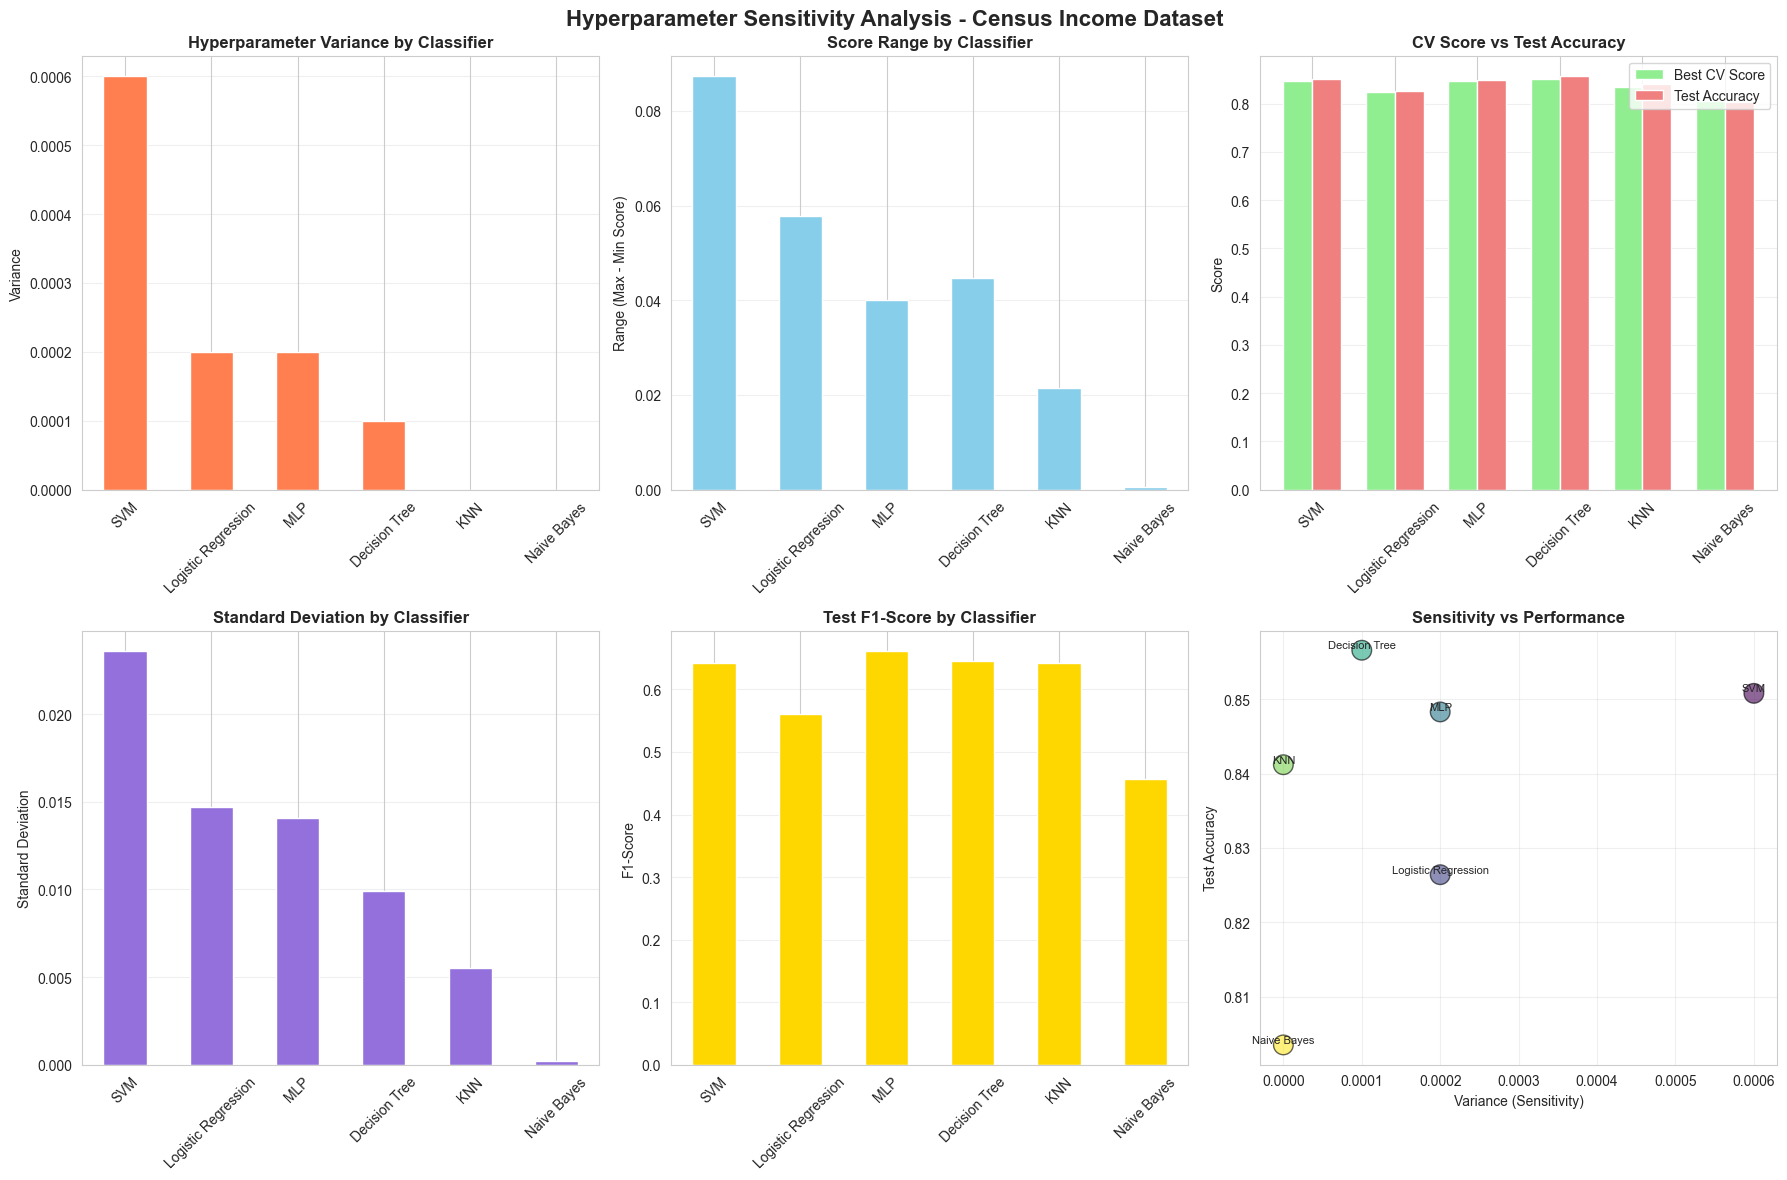

✓ Visualizations saved to: outputs/figures/census_sensitivity_analysis.png


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Sensitivity Analysis - Census Income Dataset', fontsize=16, fontweight='bold')

# 1. Variance comparison
ax = axes[0, 0]
sensitivity_summary.plot(x='Classifier', y='Variance', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('Hyperparameter Variance by Classifier', fontweight='bold')
ax.set_ylabel('Variance')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 2. Range comparison
ax = axes[0, 1]
sensitivity_summary.plot(x='Classifier', y='Range', kind='bar', ax=ax, color='skyblue', legend=False)
ax.set_title('Score Range by Classifier', fontweight='bold')
ax.set_ylabel('Range (Max - Min Score)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 3. Best CV Score vs Test Accuracy
ax = axes[0, 2]
x_pos = np.arange(len(sensitivity_summary))
width = 0.35
ax.bar(x_pos - width/2, sensitivity_summary['Best CV Score'], width, label='Best CV Score', color='lightgreen')
ax.bar(x_pos + width/2, sensitivity_summary['Test Accuracy'], width, label='Test Accuracy', color='lightcoral')
ax.set_title('CV Score vs Test Accuracy', fontweight='bold')
ax.set_ylabel('Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(sensitivity_summary['Classifier'], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Standard Deviation comparison
ax = axes[1, 0]
sensitivity_summary.plot(x='Classifier', y='Std Dev', kind='bar', ax=ax, color='mediumpurple', legend=False)
ax.set_title('Standard Deviation by Classifier', fontweight='bold')
ax.set_ylabel('Standard Deviation')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 5. Test F1 Score
ax = axes[1, 1]
sensitivity_summary.plot(x='Classifier', y='Test F1', kind='bar', ax=ax, color='gold', legend=False)
ax.set_title('Test F1-Score by Classifier', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 6. Sensitivity vs Performance scatter
ax = axes[1, 2]
scatter = ax.scatter(sensitivity_summary['Variance'], sensitivity_summary['Test Accuracy'], 
                     s=200, c=range(len(sensitivity_summary)), cmap='viridis', alpha=0.6, edgecolors='black')
for idx, row in sensitivity_summary.iterrows():
    ax.annotate(row['Classifier'], (row['Variance'], row['Test Accuracy']), 
                fontsize=8, ha='center', va='bottom')
ax.set_title('Sensitivity vs Performance', fontweight='bold')
ax.set_xlabel('Variance (Sensitivity)')
ax.set_ylabel('Test Accuracy')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/census_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to: outputs/figures/census_sensitivity_analysis.png")

## 6. Detailed Hyperparameter Analysis for Each Classifier

In [7]:
# For each classifier, visualize how performance varies with each hyperparameter
for name in grid_results.keys():
    cv_results = grid_results[name]['cv_results']
    params = grid_results[name]['best_params']
    
    print(f"\n{'='*80}")
    print(f"Detailed Analysis: {name}")
    print(f"{'='*80}")
    
    # Create DataFrame from CV results
    results_df = pd.DataFrame(cv_results)
    
    # Display top 10 configurations
    print(f"\nTop 10 Hyperparameter Configurations:")
    top_10 = results_df.nsmallest(10, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
    for idx, row in top_10.iterrows():
        print(f"  Rank {int(results_df.loc[idx, 'rank_test_score'])}: Score={row['mean_test_score']:.4f} (+/-{row['std_test_score']:.4f})")
        print(f"    Params: {row['params']}")
    
    # Save detailed results
    results_df.to_csv(f'outputs/gridsearch/census_{name.replace(" ", "_").lower()}_gridsearch.csv', index=False)
    print(f"\n✓ Detailed results saved to: outputs/gridsearch/census_{name.replace(' ', '_').lower()}_gridsearch.csv")

print(f"\n{'='*80}")
print("✓ Detailed hyperparameter analysis complete")
print(f"{'='*80}")


Detailed Analysis: KNN

Top 10 Hyperparameter Configurations:
  Rank 1: Score=0.8347 (+/-0.0030)
    Params: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
  Rank 2: Score=0.8344 (+/-0.0031)
    Params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
  Rank 3: Score=0.8336 (+/-0.0016)
    Params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
  Rank 4: Score=0.8335 (+/-0.0018)
    Params: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}
  Rank 5: Score=0.8329 (+/-0.0032)
    Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
  Rank 6: Score=0.8316 (+/-0.0009)
    Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
  Rank 7: Score=0.8312 (+/-0.0020)
    Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
  Rank 8: Score=0.8307 (+/-0.0034)
    Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
  Rank 9: Score=0.8305 (+/-0.0032)
   

## 7. Key Findings Summary

In [8]:
print("\n" + "="*80)
print("KEY FINDINGS - CENSUS INCOME DATASET")
print("="*80)

print(f"\n1. Dataset Characteristics:")
print(f"   - Samples: {len(df)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Classes: Binary (Income >50K vs <=50K)")

print(f"\n2. Best Performing Classifier:")
best_clf = sensitivity_summary.loc[sensitivity_summary['Test Accuracy'].idxmax()]
print(f"   - Classifier: {best_clf['Classifier']}")
print(f"   - Test Accuracy: {best_clf['Test Accuracy']:.4f}")
print(f"   - Test F1: {best_clf['Test F1']:.4f}")

print(f"\n3. Hyperparameter Sensitivity:")
print(f"   - Most Sensitive: {sensitivity_summary.iloc[0]['Classifier']} (Variance: {sensitivity_summary.iloc[0]['Variance']:.6f})")
print(f"   - Least Sensitive: {sensitivity_summary.iloc[-1]['Classifier']} (Variance: {sensitivity_summary.iloc[-1]['Variance']:.6f})")
print(f"   - Sensitivity Ratio: {sensitivity_summary.iloc[0]['Variance'] / sensitivity_summary.iloc[-1]['Variance']:.2f}x")

print(f"\n4. Performance Ranges:")
for idx, row in sensitivity_summary.iterrows():
    print(f"   - {row['Classifier']}: {row['Range']:.4f} (Max-Min score difference)")

print("\n" + "="*80)
print("✓ Analysis complete for Census Income dataset")
print("="*80)


KEY FINDINGS - CENSUS INCOME DATASET

1. Dataset Characteristics:
   - Samples: 32561
   - Features: 14
   - Classes: Binary (Income >50K vs <=50K)

2. Best Performing Classifier:
   - Classifier: Decision Tree
   - Test Accuracy: 0.8566
   - Test F1: 0.6463

3. Hyperparameter Sensitivity:
   - Most Sensitive: SVM (Variance: 0.000600)
   - Least Sensitive: Naive Bayes (Variance: 0.000000)
   - Sensitivity Ratio: infx

4. Performance Ranges:
   - SVM: 0.0873 (Max-Min score difference)
   - Logistic Regression: 0.0577 (Max-Min score difference)
   - MLP: 0.0401 (Max-Min score difference)
   - Decision Tree: 0.0448 (Max-Min score difference)
   - KNN: 0.0215 (Max-Min score difference)
   - Naive Bayes: 0.0006 (Max-Min score difference)

✓ Analysis complete for Census Income dataset
